# Detecting rooftop available surface for installing PV modules in satellite images using Machine Learning

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from train.train import *
from tempfile import TemporaryFile

from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *

from plots.plots import *

%load_ext autoreload
%autoreload 2

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_torch() # For reproducibility we set the seed with a seed_torch() method that set the seed in numpy and pytorch

# Loading the Data Set

In [3]:
folder_path_train_image = 'data/train/images'
folder_path_train_masks = 'data/train/labels'
folder_path_test_image = 'data/test/images'
folder_path_test_masks = 'data/test/labels'
folder_path_val_image = 'data/val/images'
folder_path_val_masks = 'data/val/labels'

# Load dataset
train_set = DataLoaderSegmentation(folder_path_train_image,folder_path_train_masks) # 80%
test_set = DataLoaderSegmentation(folder_path_test_image,folder_path_test_masks,augment=False)# 10%, no augmentation
val_set = DataLoaderSegmentation(folder_path_val_image,folder_path_val_masks,augment=False) # 10%, no augmentation

# Init data loader
train_loader = DataLoader(train_set,batch_size=2, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=2, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=2 , shuffle=True ,num_workers=0)
print(len(train_set),len(test_set),len(val_set))


420 53 52


In [4]:
model = UNet(3,1,False).to(device)

# Regular training
This is a simple training loop. We can tune the num_epochs, the learning rate and the parameter of the loss function.

In [5]:
# Init training parameters
num_epochs = 130
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([4]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs)

Epoch n. 0 Train Loss 1.63 Train Iou 0.0024373360973015527 Time Remaining 215.3 min
----------------------------------------------
Epoch n. 25 Train Loss 0.96 Train Iou 0.47315047334379 Time Remaining 146.9 min
----------------------------------------------
Epoch n. 50 Train Loss 0.75 Train Iou 0.5736589163528969 Time Remaining 118.9 min
----------------------------------------------
Epoch n. 75 Train Loss 0.66 Train Iou 0.6178255557286596 Time Remaining 76.9 min
----------------------------------------------
Epoch n. 100 Train Loss 0.57 Train Iou 0.6612856829729316 Time Remaining 42.4 min
----------------------------------------------
Epoch n. 125 Train Loss 0.5 Train Iou 0.6804895261455238 Time Remaining 7.0 min
----------------------------------------------


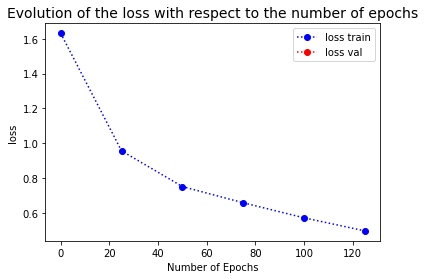

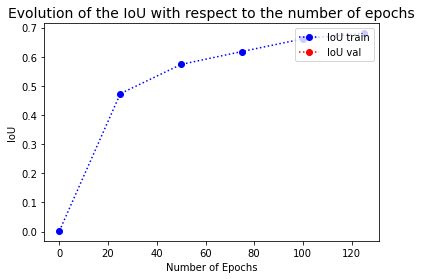

In [6]:
# Visualize the evolution of the loss and the IoU, either on the train or validation set.
plot_train_val(history_train_loss,history_val_loss,period=25, al_param=False, metric='loss')
plot_train_val(history_train_iou,history_val_iou,period=25, al_param=False, metric='IoU')

## Cross Validation
We can perform K-fold cross validation on our training set, to have an estimate of the mean iou and accuracy we may hope to achieve. Note that K-Fold CV is not considered as appropriate for CNN parameters tuning, since it is very costly.

# Export or import a model

## Export a model 

In [7]:
torch.save(model.state_dict(), 'model/'+input('path raise 230')+".pt")

path raise 230path raise 130


## Import a model 

In [5]:
path = 'model/'+input('path raise 230')+".pt"
model = UNet(3,1,False).to(device)
model.load_state_dict(torch.load(path))

path raise 230path raise 230


<All keys matched successfully>

# Evaluation of the model
We can evaluate the model to have the mean (IoU, Accuracy) on every data set, and print the number of parameters of the Unet.
Mean iou_test, acc_test, recall_test and precision_test

In [6]:
print('Train:', test_model(train_loader,model))
print('Val:', test_model(val_loader,model))
print('Test:', test_model(test_loader,model))

Train: [0.7523972527625379, 0.9581765491055944, 0.8628920916455884, 0.8535259463546262]
Val: [0.6104611167791139, 0.9195704615384616, 0.7733031108341384, 0.7693448452524703]
Test: [0.5565921008746837, 0.9033385660377358, 0.6952253724059007, 0.72680312021061]


# Visualization of the model
With the model we trained or imported, we can display from the test_loader examples of its prediction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iou: 0.7716
Accuracy: 0.9852


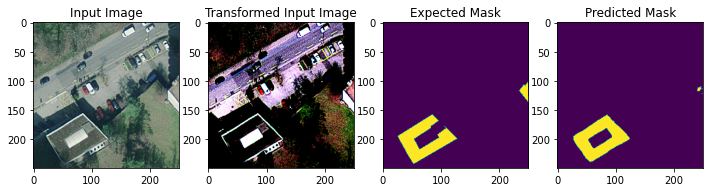

In [12]:
# Get the input, transformed input and prediction made by the model
model.eval()
index_random_sample = int(np.random.random()*len(test_loader.dataset))
(x,y,z) = test_loader.dataset.__getitem__(index_random_sample,show_og=True)
ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()

# Display all 4 images
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)
ax1 = fig.add_subplot(1,4,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,4,2)
ax2.title.set_text('Transformed Input Image')
ax3 = fig.add_subplot(1,4,3)
ax3.title.set_text('Expected Mask')
ax4 = fig.add_subplot(1,4,4)
ax4.title.set_text('Predicted Mask')

ax1.imshow(z)
ax2.imshow(np.transpose(x.numpy(),(1,2,0)))
ax3.imshow(y)
ax4.imshow(np.around((ypred)))

# Compute IoU and accuracy on prediction and mask
predict_iou = np.around(iou(np.around(ypred),y.numpy()),4)
predict_acc = accuracy(np.around(ypred),y.numpy())
print('Iou:',predict_iou)
print('Accuracy:', predict_acc)

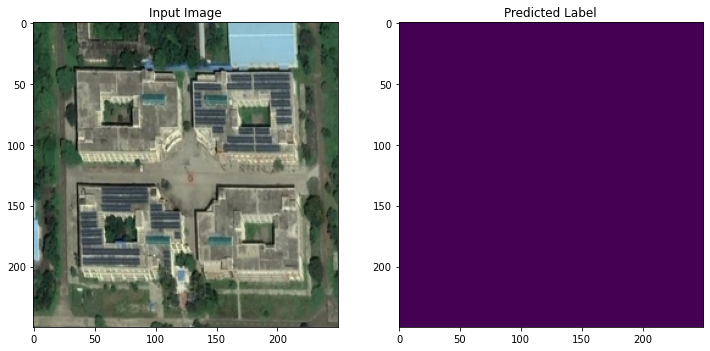

In [13]:
import_and_show(model,'Webp.net-resizeimage.png') 